In [1]:
# Data wrangling & visualizing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Machine learning 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Statistics
from statsmodels.regression.linear_model import OLS
from scipy.stats import spearmanr
from scipy.stats.contingency import association, odds_ratio

# Miscellanious
from typing import Sequence

In [2]:
# source: https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/stuff/titanic.csv
dataset = pd.read_csv("titanic.csv")
dataset = dataset.rename(columns=str.lower)

dataset["survived"] = pd.Categorical(dataset["survived"].map({0:"no",1:"yes"}), categories=["no","yes"])
dataset["pclass"] = pd.Categorical(dataset["pclass"].map({1:"1st",2:"2nd",3:"3rd"}), categories=["3rd","2nd","1st"],ordered=True)
dataset["sex"] = pd.Categorical(dataset["sex"],categories=["male","female"])

dataset.head()

,survived,pclass,name,sex,age,siblings/spouses aboard,parents/children aboard,fare
0,no,3rd,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
1,yes,1st,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833
2,yes,3rd,Miss. Laina Heikkinen,female,26.0,0,0,7.9250
3,yes,1st,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35.0,1,0,53.1000
4,no,3rd,Mr. William Henry Allen,male,35.0,0,0,8.0500


**Model parameters & dependencies**

* Age - slight polynomial dependency

In [3]:
def VIF(X:Sequence,y:Sequence, round_=4) -> float:
    r_squared = OLS(y,X).fit().rsquared
    return round(1 / (1 - r_squared),round_)

def get_vif(predictors:pd.DataFrame) -> pd.Series:
    srs = pd.Series(name="VIF")
    srs.index.name = "predictor"
    
    for predictor in predictors.columns:
        y = predictors[predictor]
        X = predictors.drop(columns=predictor)
        srs[predictor] = VIF(X=X,y=y)
        
    return srs

In [13]:
BINS = 10

bins = pd.cut(dataset["age"],bins=BINS)
total_in_bin = dataset.groupby(bins,observed=True).size()

relative_survivor_freq = dataset["survived"].cat.codes.groupby(bins,observed=True).sum() / total_in_bin

predicted_survivor = pd.DataFrame({"age":dataset["age"],"prediction":model.predict(code_frame.to_numpy())})
pred_rel_survivor_freq = predicted_survivor["prediction"].groupby(bins,observed=True).sum() / total_in_bin

residuals = relative_survivor_freq - pred_rel_survivor_freq

The linear assumption of the dependency between log-odds and age does not stand: a slight polynomial dependency would be more acceptable.
* In the 72-80 interval the actual survior rate is depicted wrongly due to the interval edges


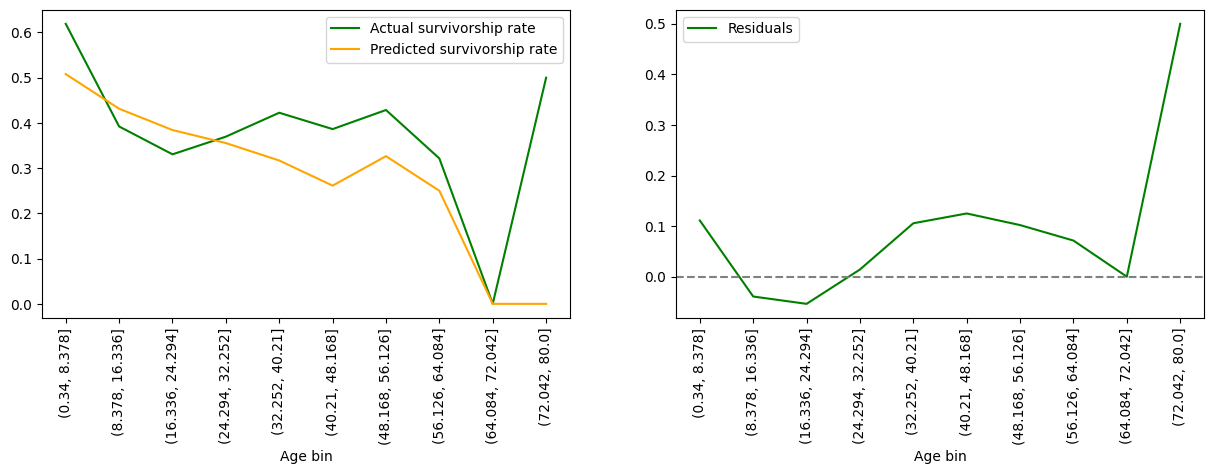

In [14]:
fig, (axl, axr) = plt.subplots(1,2,figsize=(15,4))
axl.plot(relative_survivor_freq.array,label="Actual survivorship rate",color="green")
axl.plot(pred_rel_survivor_freq.array,label="Predicted survivorship rate",color="orange")

axl.set_xticks(range(len(bins.cat.categories)))
axl.set_xticklabels(relative_survivor_freq.index,rotation=90)
axl.set_xlabel("Age bin")
axl.legend()

axr.plot(residuals.array,label="Residuals",color="green")
axr.set_xticks(range(len(bins.cat.categories)))
axr.set_xticklabels(residuals.index,rotation=90)
axr.legend()
axr.set_xlabel("Age bin")
axr.axhline(y=0,linestyle="dashed",color="grey");

print("The linear assumption of the dependency between log-odds and age does not stand: a slight polynomial dependency would be more acceptable.")
print("* In the 72-80 interval the actual survior rate is depicted wrongly due to the interval edges")

In [5]:
def get_codes(srs: pd.Series) -> pd.Series:
    if hasattr(srs, "cat"):
        return srs.cat.codes
    return srs
    
predictors = ["pclass","sex","age","parents/children aboard","siblings/spouses aboard","fare"]
code_frame = dataset[predictors].transform(get_codes)

get_vif(code_frame)

predictor
pclass                     0.0670
sex                        0.2911
age                        2.2030
parents/children aboard    1.5884
siblings/spouses aboard    1.4505
fare                       2.2599
Name: VIF, dtype: float64

In [6]:
corr_matrix = code_frame.corrwith(dataset["survived"].cat.codes,method="spearman")
corr_matrix

pclass                     0.337648
sex                        0.542152
age                       -0.030265
parents/children aboard    0.136530
siblings/spouses aboard    0.086571
fare                       0.322264
dtype: float64

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    code_frame.to_numpy(),
    dataset["survived"].cat.codes.to_numpy(),
    test_size=0.2
)

model = LogisticRegression()
model.fit(X=X_train,y=y_train);

In [8]:
code_frame.columns

Index(['pclass', 'sex', 'age', 'parents/children aboard',
       'siblings/spouses aboard', 'fare'],
      dtype='object')

In [9]:
sample = np.array([0,0,30,1,1,1]).reshape(1,-1)
model.predict(sample)

array([0], dtype=int8)

In [12]:
round(model.score(X_test,y_test),4)

0.7753